In [2]:
# importing all necessary libraries

import imageio
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [51]:
# some general and helper functions

def float_to_int_HSI(img_hsi):
    # Expected input:
    #   channel 1 => H => [0, 2pi]
    #   channel 2 => S => [0, 1]
    #   channel 3 => I => [0, 1]
    
    img_hsi_copy = img_hsi.copy()
    img_hsi_norm = np.zeros(shape=(img_hsi_copy.shape), dtype=np.uint8)
    img_hsi_norm[:,:,0] = np.uint8((img_hsi_copy[:,:,0] / (2 * np.pi)) * 255)
    img_hsi_norm[:,:,1] = np.uint8(img_hsi_copy[:,:,1] * 255)
    img_hsi_norm[:,:,2] = np.uint8(img_hsi_copy[:,:,2] * 255)

    return img_hsi_norm

def int_to_float_HSI(img_hsi):
    # Expected input:
    #   channel 1 => H => [0, 255]
    #   channel 2 => S => [0, 255]
    #   channel 3 => I => [0, 255]
    
    img_hsi_copy = img_hsi.copy()
    img_hsi_norm = np.zeros(shape=(img_hsi_copy.shape), dtype=np.float32)
    img_hsi_norm[:,:,0] = (img_hsi_copy[:,:,0] / 255) * (2 * np.pi)
    img_hsi_norm[:,:,1] = img_hsi_copy[:,:,1] / 255
    img_hsi_norm[:,:,2] = img_hsi_copy[:,:,2] / 255

    return img_hsi_norm

def normalize_rgb(img_rgb):
    img_rgb_copy = img_rgb.copy()
    return np.uint8(img_rgb_copy * 255)

def read_img(img_path):
    return imageio.v3.imread(img_path)

def HSI_to_rgb(img):
    h = img[:,:, 0] # expected range [0, 2pi] we actually should get from 0 to 1 as well
    s = img[:,:, 1] # expected range [0, 1]
    i = img[:,:, 2] # expected range [0, 1]

    h1 = h < 1/3 * 2 * np.pi
    h2 = (1/3 * 2 * np.pi <= h) & (h < 2/3 * 2 * np.pi)
    h3 = 2/3 * 2 * np.pi <= h     

    r = np.zeros_like(h)
    g = np.zeros_like(h)
    b = np.zeros_like(h)
    h_curr = np.zeros_like(h)

    # case 1
    h_curr[h1] = h[h1]
    b[h1] = i[h1] * (1 - s[h1])
    r[h1] = i[h1] * (1 + (s[h1] * np.cos(h_curr[h1])) / (np.cos(np.pi/3 - h_curr[h1])))
    g[h1] = 3 * i[h1] - (r[h1] + b[h1])

    # case 2    
    h_curr[h2] = h[h2] - (2/3 * np.pi)
    r[h2] = i[h2] * (1 - s[h2])
    g[h2] = i[h2] * (1 + (s[h2] * np.cos(h_curr[h2])) / (np.cos(np.pi/3 - h_curr[h2])))
    b[h2] = 3 * i[h2] - (r[h2] + g[h2])

    # case 3
    h_curr[h3] = h[h3] - (4/3 * np.pi)
    g[h3] = i[h3] * (1 - s[h3])
    b[h3] = i[h3] * (1 + (s[h3] * np.cos(h_curr[h3])) / (np.cos(np.pi/3 - h_curr[h3])))
    r[h3] = 3 * i[h3] - (g[h3] + b[h3])    

    r = r / max(r.flatten())
    g = g / max(g.flatten())
    b = b / max(b.flatten())
    
    return np.stack((r,g,b),axis=2)

def rgb_to_HSI(img):

    with np.errstate(divide="ignore", invalid="ignore"):

        # load image with 32 floating point type
        rgb = np.float32(img)/255.0

        # Separating RGB    
        r = rgb[:,:,0]
        g = rgb[:,:,1]
        b = rgb[:,:,2]        

        # Intensity
        intensity = (r+b+g)/3

        # Saturation
        min = np.minimum(np.minimum(r,g),b)
        sat = 1 - ((3/(r+g+b+0.0000001))*min)

        # Hue
        hue = np.arccos((0.5*((r-g)+(r-b)))/((np.sqrt((r-g)**2+(r-b)*(g-b)))))
        hue[b>g] = 2*np.pi - hue[b>g]        

        return np.stack((hue,sat,intensity),axis=2)     

## 1. Histogram equalization

We can achieve histogram equalization in two main ways:

- Equalize every channel in the RGB image and then stack them together again
- Convert the image into a format where the luminance is isolated perform histogram normalization on that channel and then convert back the image to RGB

### RGB channels equalization

In [6]:
# Some code to create the histograms and images 
def create_histogram_rgb(img=None):        
    fig, axs = plt.subplots(1, 4)
    fig.suptitle('RGB Histogram and corresponding image')
    fig.set_size_inches(18.5, 5.5)

    color = ('red','green','blue') 

    cdfs = np.empty(shape=(3,256))
    hists = []
    tot_max_cdf = 0

    for i,col in enumerate(color):
        hist,_ = np.histogram(img[:,:,i].flatten(),256,[0,256])
        cdf = hist.cumsum()
        hists.append(hist)        
        cdfs[i] = cdf               
        if(cdf.max() > tot_max_cdf):
            tot_max_cdf = cdf.max()    

    for i,col in enumerate(color):        
        cdf_normalized = cdfs[i] * float(hists[i].max()) / np.max(cdfs.flatten())                     
        axs[i].plot(cdf_normalized, color = 'orange')
        axs[i].hist(img[:,:,i].ravel(),256,[0,256], color = col)        

    axs[0].legend(('cdf','histogram'), loc = 'upper left')  
    axs[1].legend(('cdf','histogram'), loc = 'upper left')  
    axs[2].legend(('cdf','histogram'), loc = 'upper left')  
    axs[3].imshow(img)

    plt.plot()
    plt.show()

The most common method to perform histogram equalization is to process every channel in the RGB image separately and then stack them together to form another RGB image.

Following this approach, we performed the first histogram equalization using the built-in function in OpenCV which takes in input an array of values and outputs the equalized array of values. The input and output are of type **np.uint8**

In [9]:
img_path = "../../../images/used_images/light_dark/"
img_name = "DSC_0015.jpg"

# reading the image
img_rgb = read_img(img_path+img_name)
print("Image Shape: ", img_rgb.shape)

Image Shape:  (4000, 6000, 3)


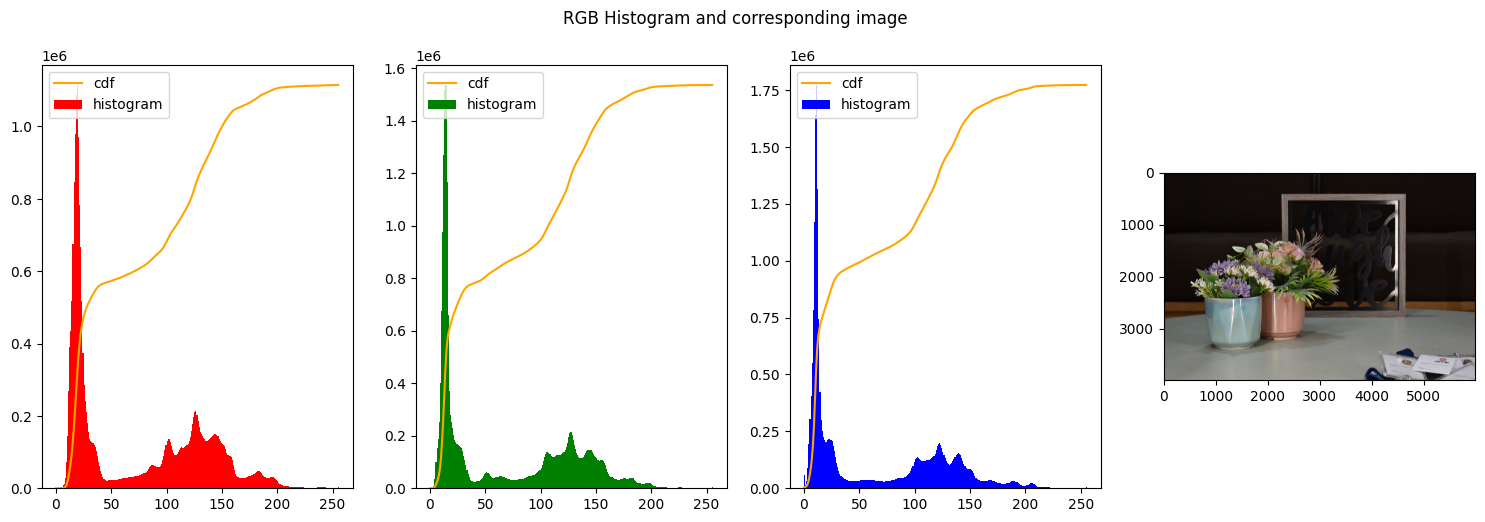

In [10]:
# Creating the histogram for every channel
create_histogram_rgb(img_rgb)

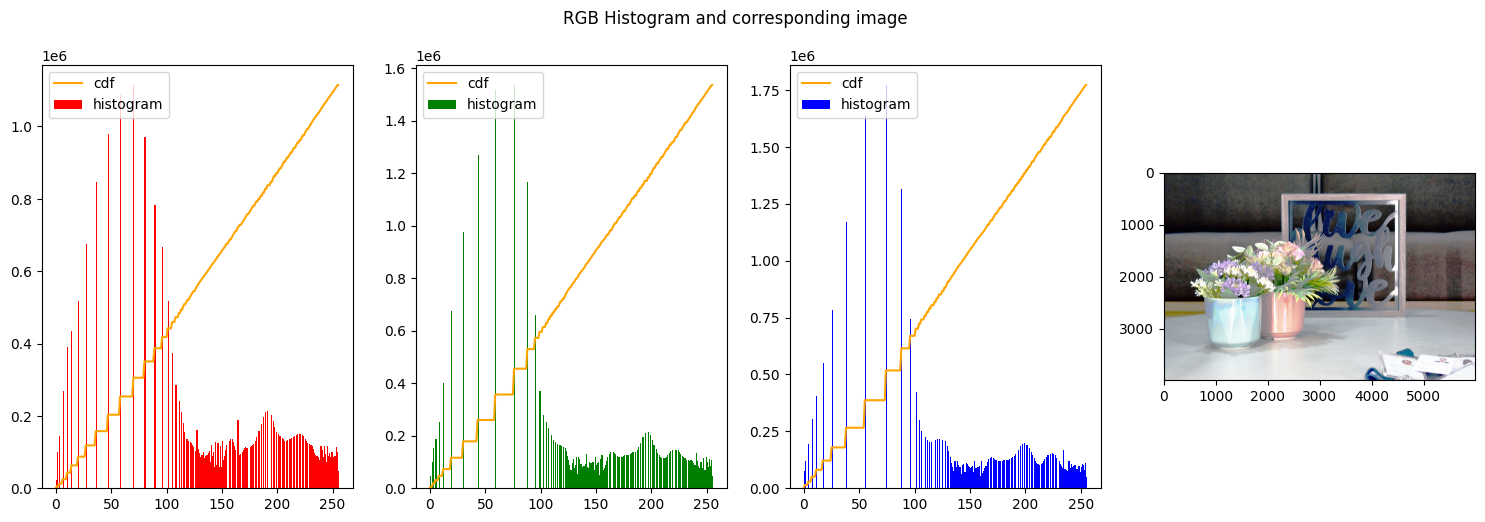

In [12]:
# function to equalize every channel and then put together again

def equalize_rgb_channels():
    img_rgb_equalized = img_rgb.copy()
    r_equal = np.uint8(img_rgb_equalized[:,:,0])
    g_equal = np.uint8(img_rgb_equalized[:,:,1])
    b_equal = np.uint8(img_rgb_equalized[:,:,2])

    r_equal = cv2.equalizeHist(r_equal)
    g_equal = cv2.equalizeHist(g_equal)
    b_equal = cv2.equalizeHist(b_equal)

    return np.stack((r_equal,g_equal,b_equal),axis=2)        

res_rgb_equal = equalize_rgb_channels()

create_histogram_rgb(res_rgb_equal)

In the first figure we can clearly see that none of the histograms resembles a uniform distribution, on the opposite the 3 histograms have a high spike on the left end of the graph, meaning a majority of dark colors and low-intensity is present, as indeed is expected from the big influence of the background.

In the second figure instead, the histograms were stretched to approximate a uniform distribution. That can be seen from the line of the cumulative distribution that is constantly increasing closely following a line.


### HSI intensity equalization

The second technique foresees that the images need first to be transformed into another color space the HSI. In the HSI color space, the three channels are Hue, Saturation and Intensity. In this color space, the intensity is not scattered among three different channels as it happens to be in RGB.

In [35]:
# Some code to create the histograms and images 
def create_histogram_hsi(img_hsi):    

    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Intensity Histogram in HSI color space and corresponding image')
    fig.set_size_inches(18.5, 5.5)
    
    hist,_ = np.histogram(img_hsi[:,:,2].flatten(),256,[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()    

    axs[0].hist((img_hsi[:,:,2]).ravel(),256,[0,255])
    axs[0].plot(cdf_normalized, color = 'r')
    axs[0].legend(('cdf','histogram'), loc = 'upper left')        
    axs[1].imshow(img_hsi)
    plt.plot()
    plt.show()

First of all we read the image and the convert it to HSI color space using the function defined in the helper function at the top of the notebook. We also normalize it to have values between 0 and 255.

C:\Users\sebastian\AppData\Local\Temp\ipykernel_9692\1627461377.py:11: RuntimeWarning: invalid value encountered in cast
  img_hsi_norm[:,:,0] = np.uint8((img_hsi_copy[:,:,0] / (2 * np.pi)) * 255)


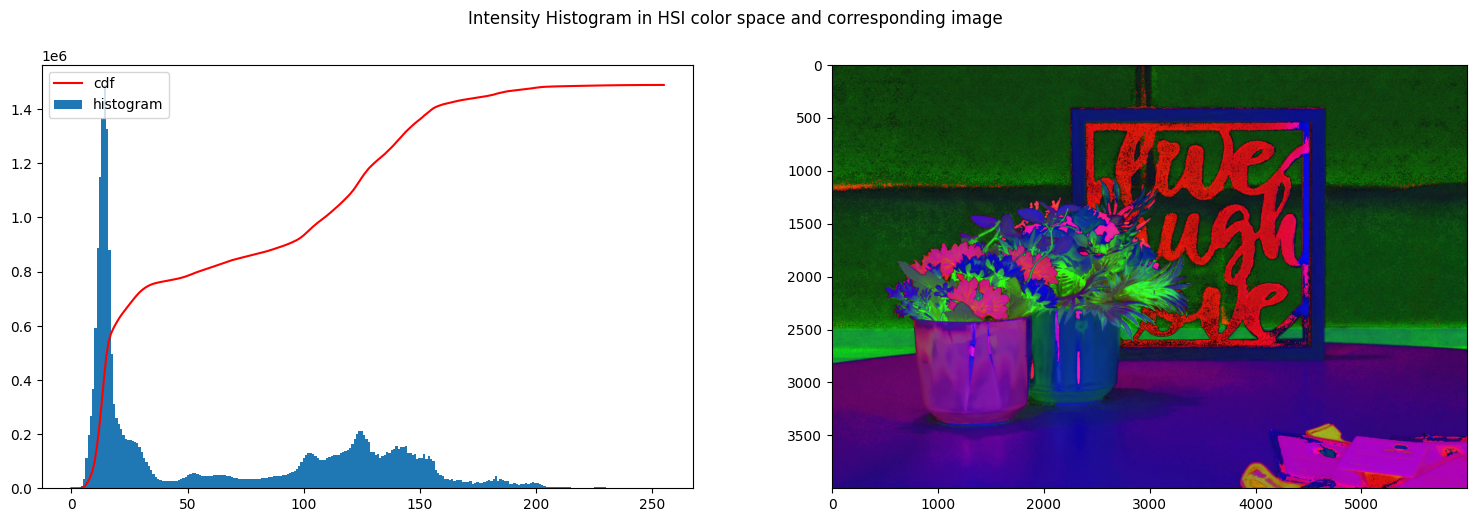

In [42]:
# convert previously used image to HSI
img_hsi = rgb_to_HSI(img_rgb)
img_hsi_norm = float_to_int_HSI(img_hsi)
create_histogram_hsi(img_hsi_norm)

We then normalize the image 

C:\Users\sebastian\AppData\Local\Temp\ipykernel_9692\1627461377.py:11: RuntimeWarning: invalid value encountered in cast
  img_hsi_norm[:,:,0] = np.uint8((img_hsi_copy[:,:,0] / (2 * np.pi)) * 255)


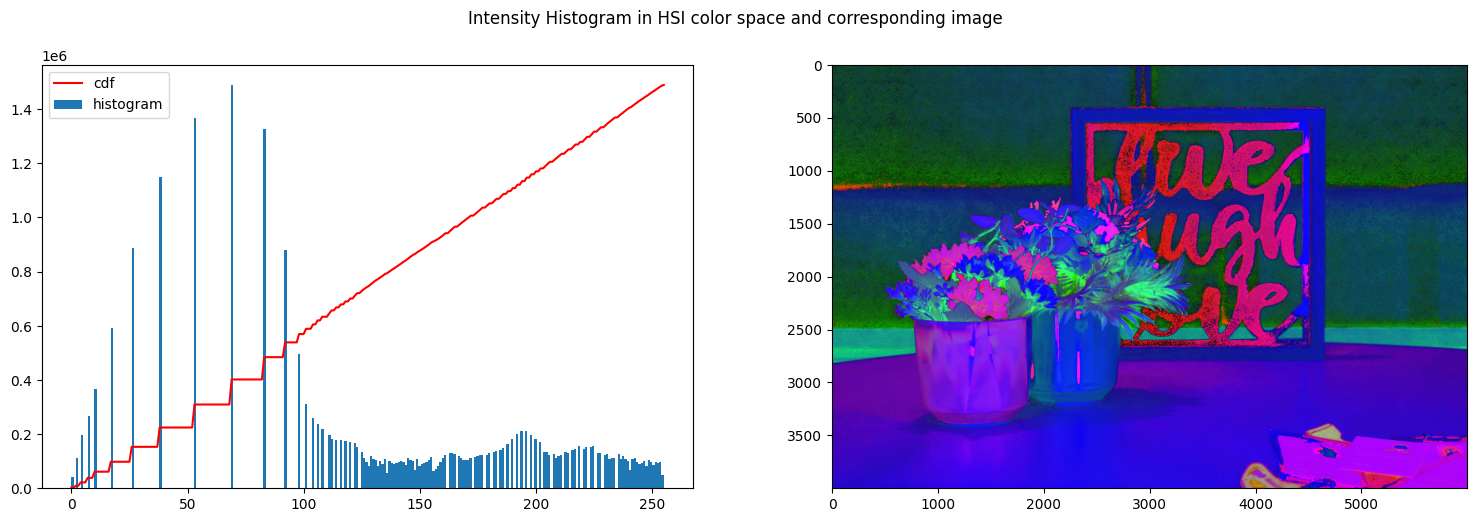

In [48]:
img_hsi_equalized = img_hsi_norm.copy()
img_hsi_equalized[:,:,2] = cv2.equalizeHist(img_hsi_equalized[:,:,2])
create_histogram_hsi(img_hsi_equalized)

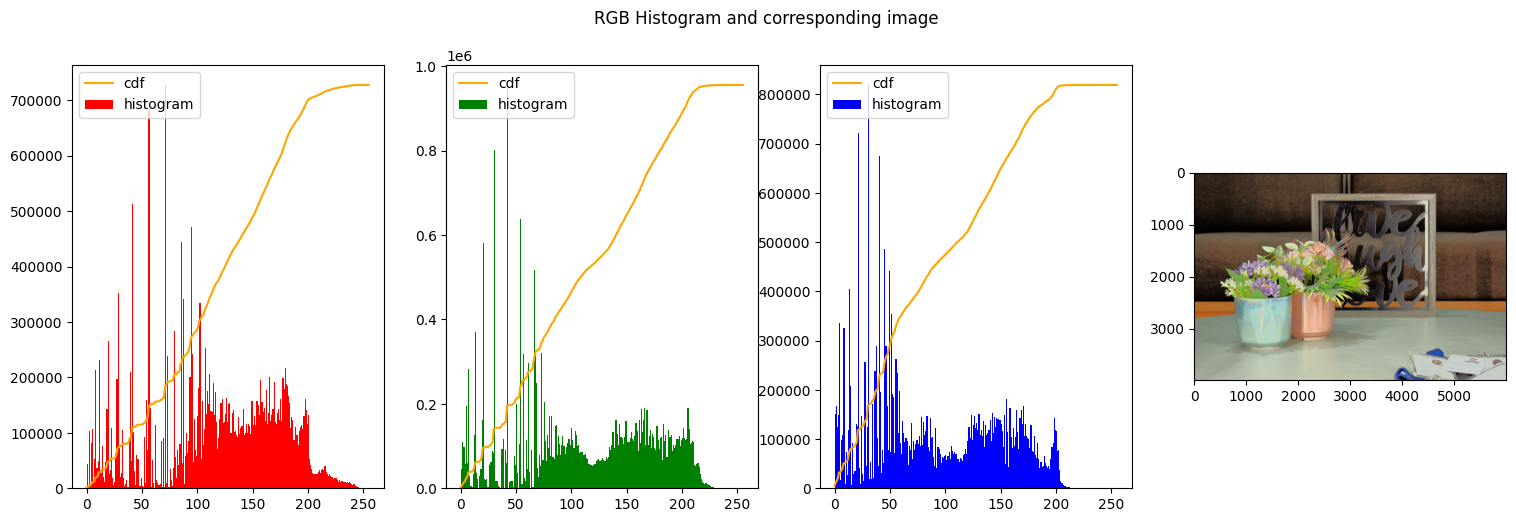

In [53]:
img_hsi_equalized_float = int_to_float_HSI(img_hsi_equalized)

new_img_rgb = HSI_to_rgb(img_hsi_equalized_float)
new_img_rgb = normalize_rgb(new_img_rgb)

create_histogram_rgb(new_img_rgb)

In [56]:
def compare(img1, img2, titles):
    res = np.hstack((img1,img2)) #stacking images side-by-side
    plt.figure(figsize=(20,10))
    plt.title('{} vs {}'.format(titles[0],titles[1]))
    plt.imshow(res,cmap='gray')

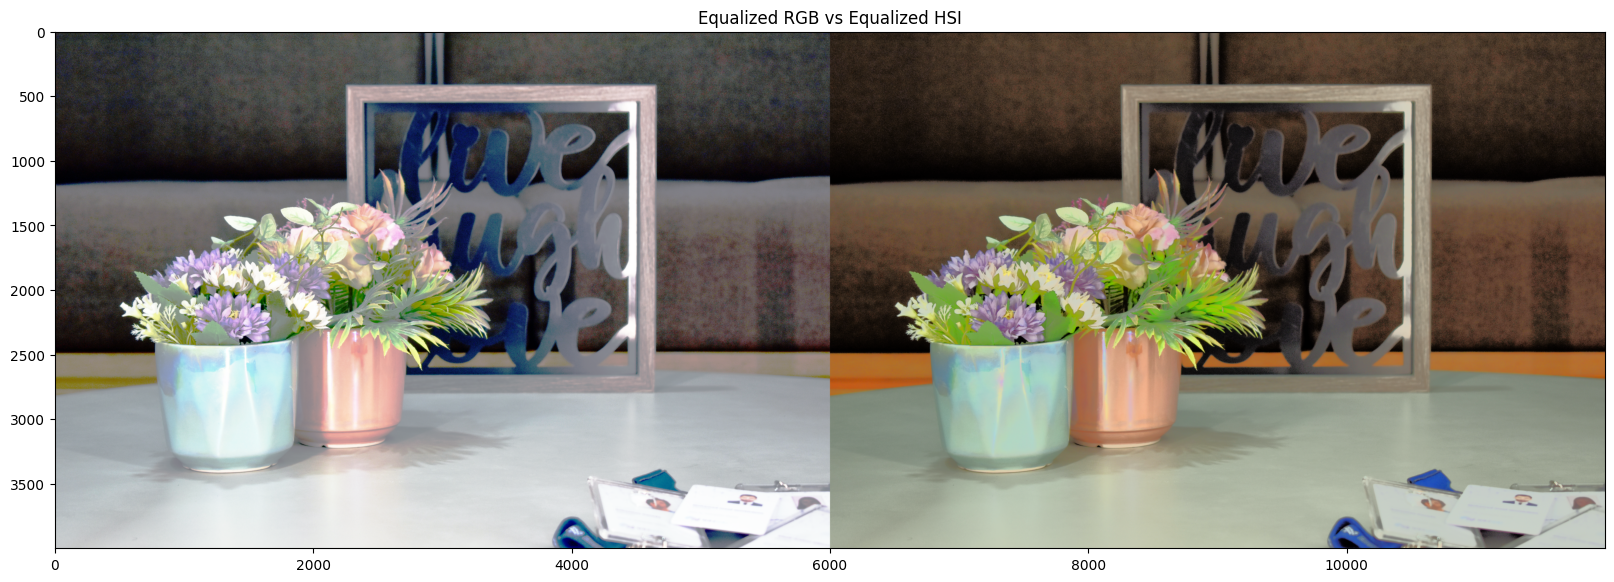

In [57]:
compare(res_rgb_equal, new_img_rgb, ["Equalized RGB", "Equalized HSI"])

## 2. Contrast streching

we implemented contrast stretching as proposed in chapter 3.2 in the book Digital Image Processing proposed as reading material in CV701. In this case we use two values namely alpha1 and alpha2, that delimits the starting point and endingn point of the streching zone in the input mapping. We then create a linear function that maps the input to an output in the range defined by beta1 and beta2. The full code is implemented in following cell.

In [80]:
# the main function to stretch the image 

def contrast_RGB(image, alpha, beta):

    if alpha[0] > beta[0] or alpha[1] > beta[1]:
        raise Exception("Alpha must be smaller than beta")

    if alpha[0] < 0 or alpha[1] < 0 or beta[0] < 0 or beta[1] < 0:
        raise Exception("Alpha and beta must be positive")
    
    if alpha[0] > 255 or alpha[1] > 255 or beta[0] > 255 or beta[1] > 255:
        raise Exception("Alpha and beta must be smaller than 256")

    max_val = image.flatten().max()

    img = image.copy()

    alpha1 = alpha[0]
    alpha2 = alpha[1]

    beta1 = beta[0]
    beta2 = beta[1]

    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]

    rn = np.zeros_like(r)
    gn = np.zeros_like(g)
    bn = np.zeros_like(b)
    
    img_bit_mask_1_r = r < alpha1
    img_bit_mask_1_g = g < alpha1
    img_bit_mask_1_b = b < alpha1

    img_bit_mask_2_r = (alpha1 <= r) & (r <= alpha2)
    img_bit_mask_2_g = (alpha1 <= g) & (g <= alpha2)
    img_bit_mask_2_b = (alpha1 <= b) & (b <= alpha2)

    img_bit_mask_3_r = alpha2 < r
    img_bit_mask_3_g = alpha2 < g
    img_bit_mask_3_b = alpha2 < b

    s1 = (beta1 / alpha1)
    b1 = beta1 - alpha1 * s1
    s2 = ((beta2 - beta1) / (alpha2 - alpha1))
    b2 = beta2 - alpha2 * s2
    s3 = ((max_val - beta2) / (max_val - alpha2))
    b3 = max_val - max_val * s3

    # case R
    rn[img_bit_mask_1_r] = img[:,:,0][img_bit_mask_1_r] * s1
    gn[img_bit_mask_1_g] = img[:,:,1][img_bit_mask_1_g] * s1
    bn[img_bit_mask_1_b] = img[:,:,2][img_bit_mask_1_b] * s1
    
    # case G
    rn[img_bit_mask_2_r] = img[:,:,0][img_bit_mask_2_r] * s2 + b2
    gn[img_bit_mask_2_g] = img[:,:,1][img_bit_mask_2_g] * s2 + b2
    bn[img_bit_mask_2_b] = img[:,:,2][img_bit_mask_2_b] * s2 + b2
    
    # case B
    rn[img_bit_mask_3_r] = img[:,:,0][img_bit_mask_3_r] * s3 + b3
    gn[img_bit_mask_3_g] = img[:,:,1][img_bit_mask_3_g] * s3 + b3
    bn[img_bit_mask_3_b] = img[:,:,2][img_bit_mask_3_b] * s3 + b3

    return np.stack([rn, gn, bn], axis=2)

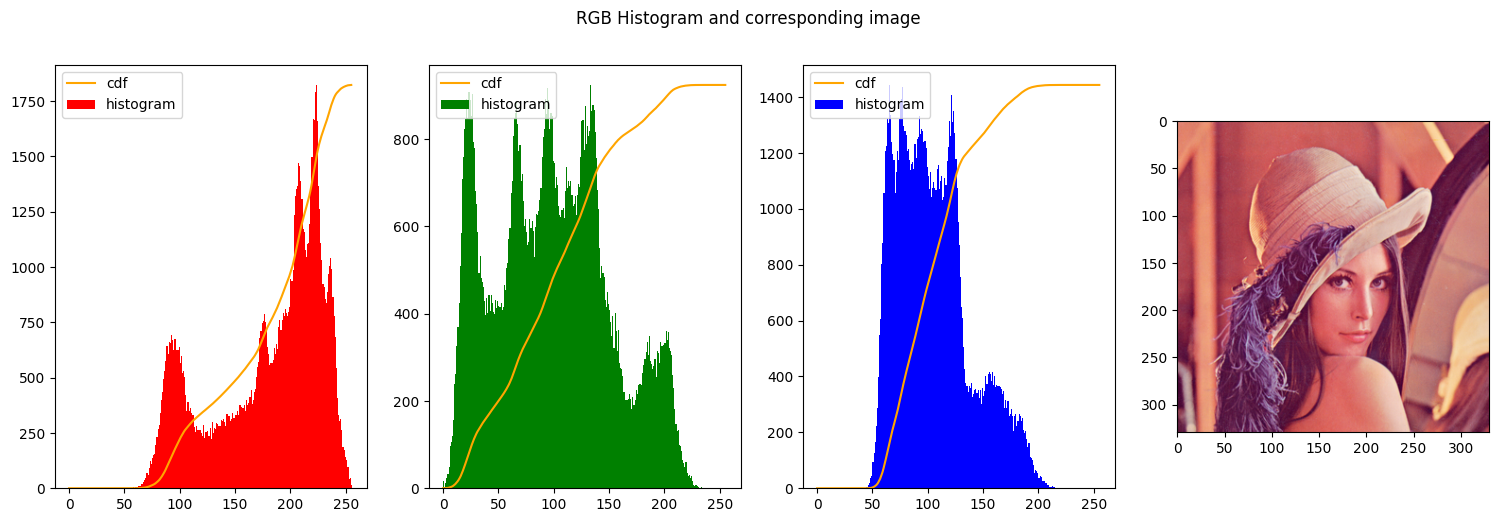

In [81]:
img_path = "./"
img_name = "lenna.png"

img_rgb = read_img(img_path + img_name)

create_histogram_rgb(img_rgb)

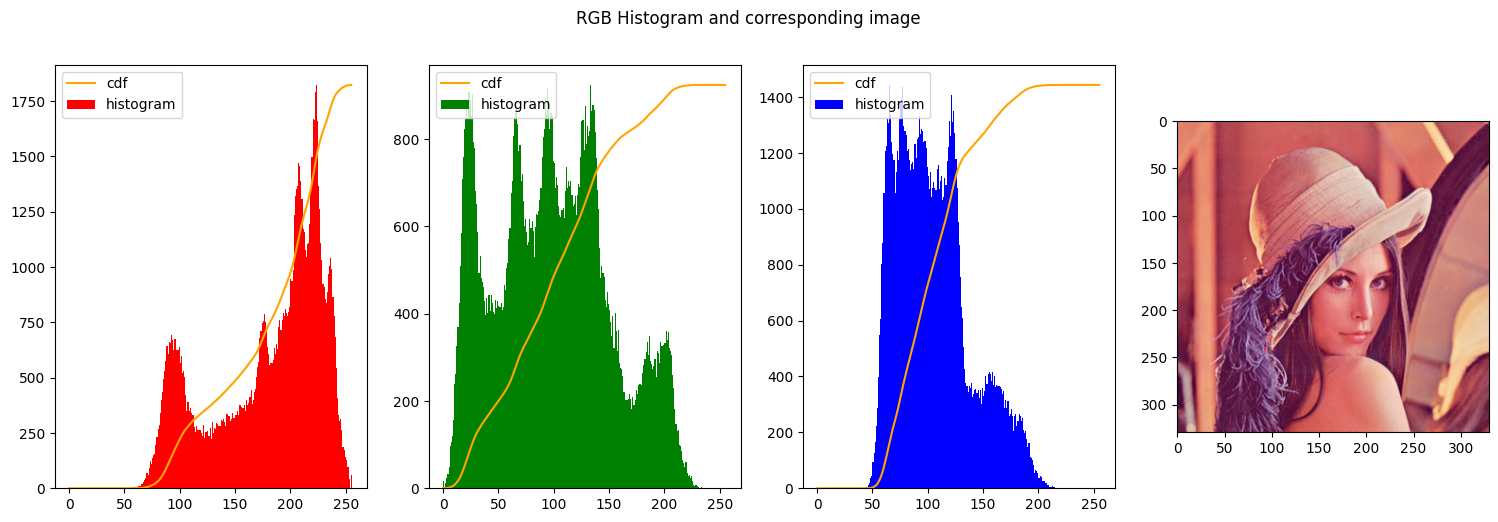

In [82]:
img_stretched = contrast_RGB(img_rgb, [10, 254], [10, 255])
create_histogram_rgb(img_stretched)

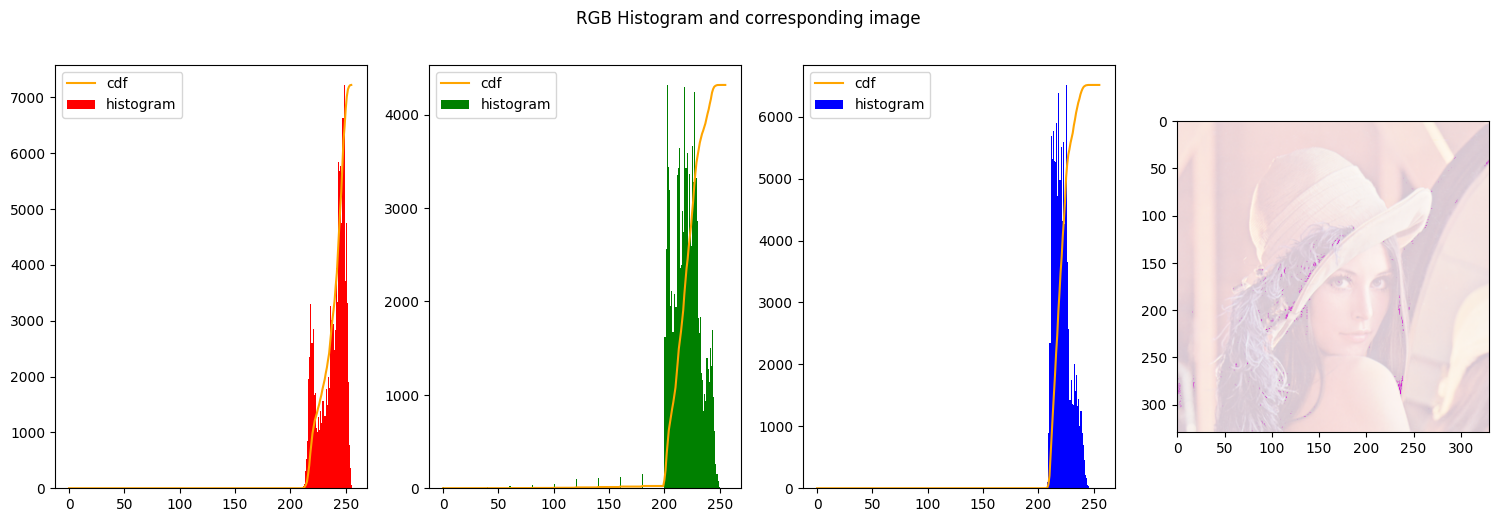

In [83]:
img_stretched = contrast_RGB(img_rgb, [10, 254], [200, 255])
create_histogram_rgb(img_stretched)

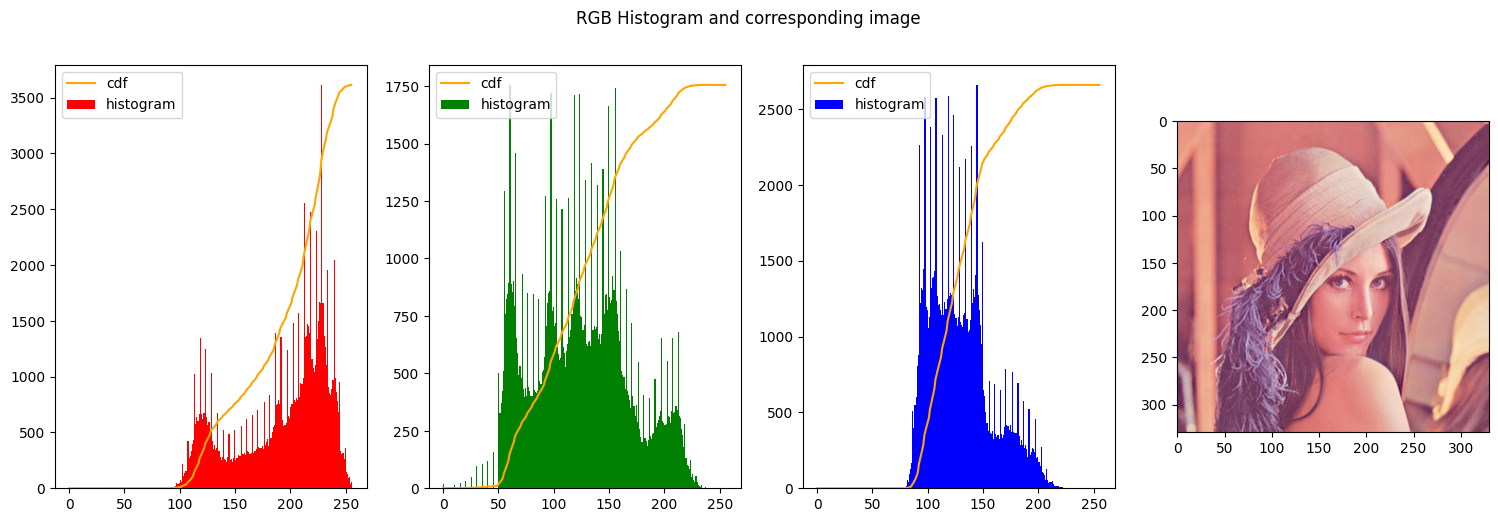

In [84]:
img_stretched = contrast_RGB(img_rgb, [10, 254], [50, 255])
create_histogram_rgb(img_stretched)